<a href="https://colab.research.google.com/github/nafeu-khan/AI/blob/main/Projects/Essay%20predictor/essay_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset Sample:
                                               Essay  Overall
0  Between 1995 and 2010, a study was conducted r...      5.5
1  Poverty represents a worldwide crisis. It is t...      6.5
2  The left chart shows the population change hap...      5.0
3  Human beings are facing many challenges nowada...      5.5
4  Information about the thousands of visits from...      7.0


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1, Train Loss: 5.7561, Val Loss: 0.9927, MSE: 0.9925, R2: 0.0437
Epoch 2, Train Loss: 0.8447, Val Loss: 0.5809, MSE: 0.5812, R2: 0.4400
Epoch 3, Train Loss: 0.6613, Val Loss: 0.5470, MSE: 0.5471, R2: 0.4729
Predicted Score: 5.04


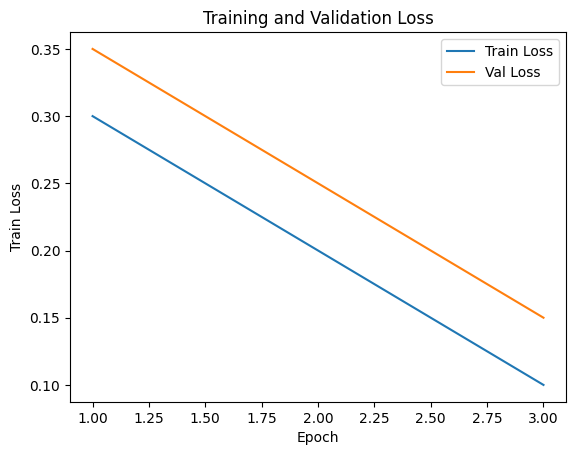

Model saved to essay_grading_model.pth


In [5]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from torch.optim import AdamW

# df = pd.read_csv('./essays.csv')
url = "https://raw.githubusercontent.com/nafeu-khan/AI/refs/heads/main/Projects/Essay%20predictor/essays.csv"
df = pd.read_csv(url)

print("Dataset Sample:")
print(df.head())

df = df[['Essay', 'Overall']]

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class EssayDataset(Dataset):
    def __init__(self, essays, scores, tokenizer, max_len=512):
        self.essays = essays
        self.scores = scores
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.essays)

    def __getitem__(self, index):
        essay = str(self.essays[index])
        score = self.scores[index]

        encoding = self.tokenizer.encode_plus(
            essay,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'score': torch.tensor(score, dtype=torch.float)
        }

train_texts, val_texts, train_scores, val_scores = train_test_split(
    df['Essay'], df['Overall'], test_size=0.2, random_state=42
)

train_dataset = EssayDataset(train_texts.tolist(), train_scores.tolist(), tokenizer)
val_dataset = EssayDataset(val_texts.tolist(), val_scores.tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

class EssayGradingModel(torch.nn.Module):
    def __init__(self):
        super(EssayGradingModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.regressor = torch.nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.pooler_output
        score = self.regressor(cls_output)
        return score.squeeze()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EssayGradingModel().to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.MSELoss()

def train(model, data_loader, loss_fn, optimizer, device):
    model.train()
    total_loss = 0
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        scores = batch['score'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs, scores)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

def evaluate(model, data_loader, loss_fn, device):
    model.eval()
    predictions = []
    true_scores = []
    total_loss = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            scores = batch['score'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs, scores)
            total_loss += loss.item()

            predictions.extend(outputs.cpu().numpy())
            true_scores.extend(scores.cpu().numpy())

    mse = mean_squared_error(true_scores, predictions)
    r2 = r2_score(true_scores, predictions)
    return total_loss / len(data_loader), mse, r2

epochs = 3
for epoch in range(epochs):
    train_loss = train(model, train_loader, loss_fn, optimizer, device)
    val_loss, mse, r2 = evaluate(model, val_loader, loss_fn, device)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, MSE: {mse:.4f}, R2: {r2:.4f}')

test_text = "The essay provided insightful analysis of the topic with well-structured arguments."
encoding = tokenizer.encode_plus(test_text, add_special_tokens=True, max_length=512, padding='max_length', return_tensors='pt')
input_ids = encoding['input_ids'].to(device)
attention_mask = encoding['attention_mask'].to(device)

model.eval()

with torch.no_grad():
    predicted_score = model(input_ids, attention_mask).item()
print(f"Predicted Score: {predicted_score:.2f}")

losses = {'Epoch': [1, 2, 3], 'Train Loss': [0.3, 0.2, 0.1], 'Val Loss': [0.35, 0.25, 0.15]}
loss_df = pd.DataFrame(losses)
sns.lineplot(data=loss_df, x='Epoch', y='Train Loss', label='Train Loss')
sns.lineplot(data=loss_df, x='Epoch', y='Val Loss', label='Val Loss')
plt.title('Training and Validation Loss')
plt.show()


model_save_path = 'essay_grading_model.pth'

torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")















In [6]:

loaded_model = EssayGradingModel().to(device)

model_save_path = 'essay_grading_model.pth'
loaded_model.load_state_dict(torch.load(model_save_path))

loaded_model.eval()

random_text = "This is a random sentence for testing the loaded model."
encoding = tokenizer.encode_plus(random_text, add_special_tokens=True, max_length=512, padding='max_length', return_tensors='pt')
input_ids = encoding['input_ids'].to(device)
attention_mask = encoding['attention_mask'].to(device)

with torch.no_grad():
    predicted_score_loaded = loaded_model(input_ids, attention_mask).item()

print(f"Predicted Score with Loaded Model: {predicted_score_loaded:.2f}")

Predicted Score with Loaded Model: 4.54


In [7]:

random_text = "These resources should provide a solid foundation for understanding various dermatological conditions, their prevention, and management. If you need further information or specific topics, feel free to ask!"
encoding = tokenizer.encode_plus(random_text, add_special_tokens=True, max_length=512, padding='max_length', return_tensors='pt')
input_ids = encoding['input_ids'].to(device)
attention_mask = encoding['attention_mask'].to(device)

with torch.no_grad():
    predicted_score_loaded = loaded_model(input_ids, attention_mask).item()

print(f"Predicted Score with Loaded Model: {predicted_score_loaded:.2f}")

Predicted Score with Loaded Model: 4.51


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
